## Initialisation

### Dependencies

#### Third party

In [1]:
from matplotlib import pyplot as plt, ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import statsmodels.api as sm
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy import optimize

#### Personal notebooks

In [2]:
import ipynb
from ipynb.fs.full.dataset_initialisation import (
    x,
    y,
    x_label,
    y_label,
    OUTPUT_DIR,
    COMBINED_OUTPUT_DIR,
    PROJECT_NAME,
    ifile,
    ofile,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    group_by,
    find_nearest,
)

An index file already exists for Additive Manufactured SS 316L. Do you want to re-initalise? (Y/n): y
An index file already exists for AA 2195 T8. Do you want to re-initalise? (Y/n): y
An index file already exists for AA 2195 Solutionized. Do you want to re-initalise? (Y/n): y
An index file already exists for AA 2195 T6. Do you want to re-initalise? (Y/n): y
An output file already exists for Additive Manufactured SS 316L. Do you want to re-initalise? (Y/n): y
An output file already exists for AA 2195 T8. Do you want to re-initalise? (Y/n): y
An output file already exists for AA 2195 Solutionized. Do you want to re-initalise? (Y/n): y
An output file already exists for AA 2195 T6. Do you want to re-initalise? (Y/n): y


### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Plot of Engineering Strain v/s Engineering Stress

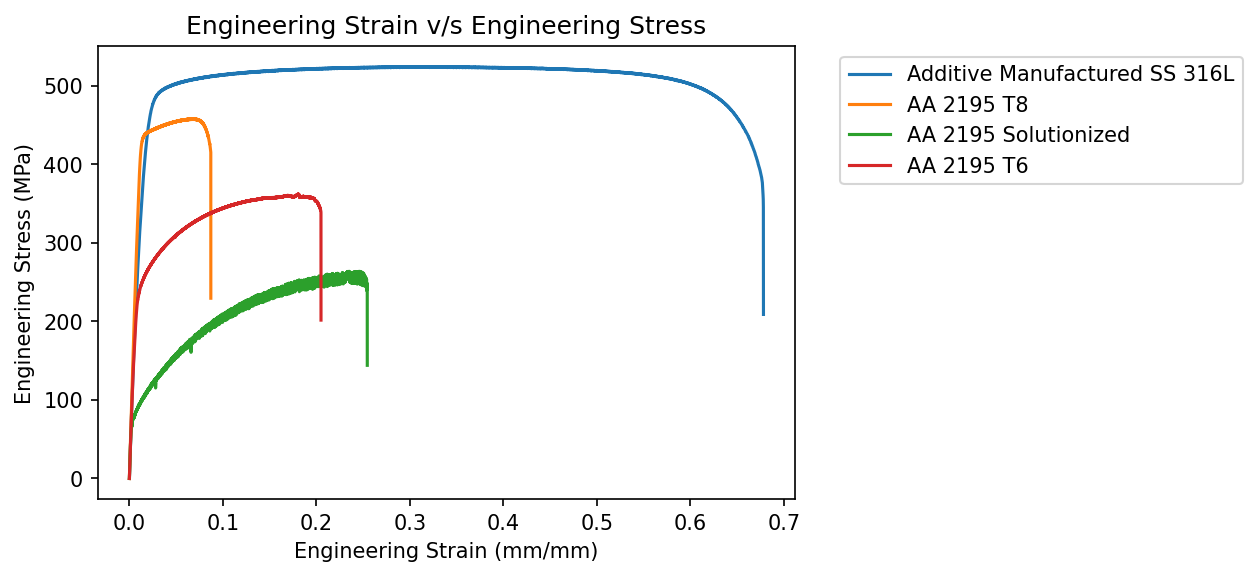

In [3]:
fig, ax = plt.subplots(1,1)

for i in range(len(x)):
    x[i], y[i] = group_by(x[i], y[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.plot(x[i],y[i])

ax.legend(PROJECT_NAME, loc='upper left', bbox_to_anchor=(1.05, 1))
ax.set_title('Engineering Strain v/s Engineering Stress')
fig.set_size_inches(6, 4)
fig.set_dpi(150)
fig.savefig(
    f'{COMBINED_OUTPUT_DIR}/Engineering stress vs strain',
    bbox_inches='tight',
    facecolor='white',
    transparent=True,
)

### Reduce noise in the curve

In order to calculate YS, have trimmed the x-axis.

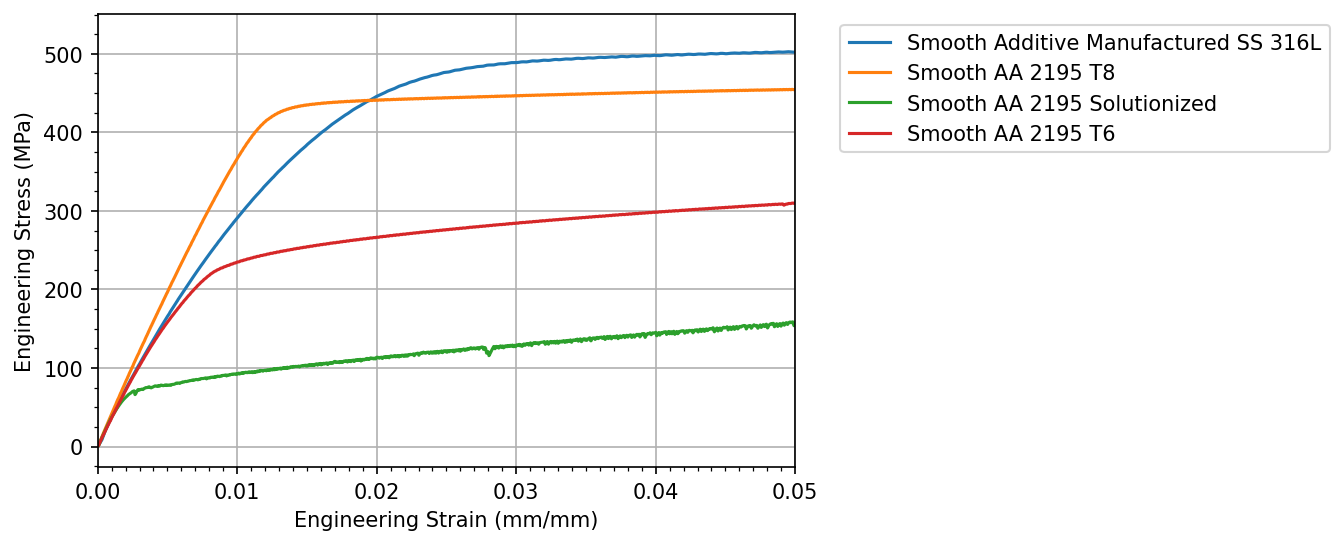

In [4]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

fig , ax = plt.subplots(1,1)

legends = []

y_smooth = []

for i in range(len(x)):
    y_smooth.append(smooth(y[i],5))
    _ = ax.plot(x[i], y_smooth[i])
    legends.append(f'Smooth {PROJECT_NAME[i]}')

ax.legend(legends, loc='upper left', bbox_to_anchor=(1.05, 1))
ax.grid(True)
ax.set_xlim(0,0.05)
ax.xaxis.set_minor_locator(MultipleLocator(0.001))
ax.yaxis.set_minor_locator(MultipleLocator(25))
_ = ax.set_xlabel(x_label)
_ = ax.set_ylabel(y_label)

fig.set_size_inches(6, 4)
fig.set_dpi(150)

## Calculation of Young's modulus ($E$)

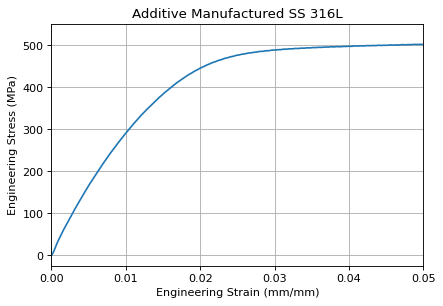

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in Additive Manufactured SS 316L's dataset: 0.015
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 400
Young's Modulus: 24.528471752330667 GPa


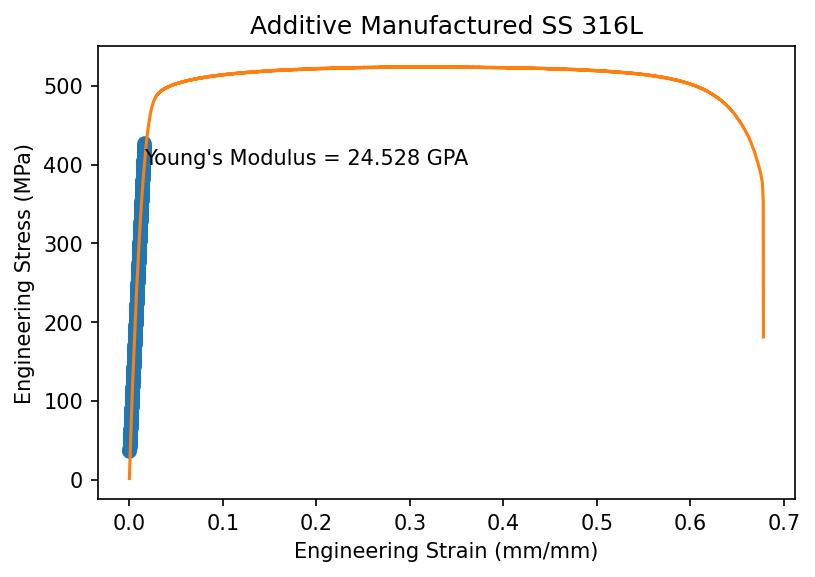

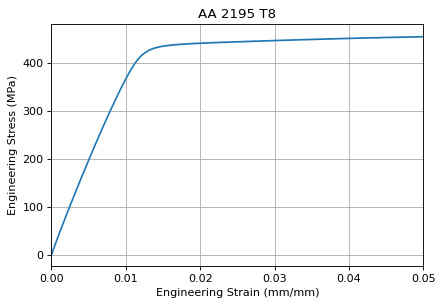

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in AA 2195 T8's dataset: 0.012
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 402
Young's Modulus: 35.83021577597949 GPa


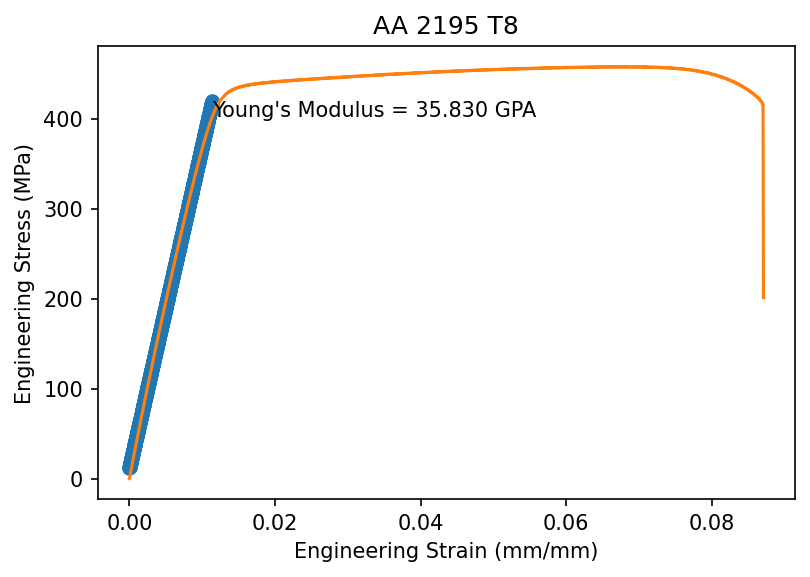

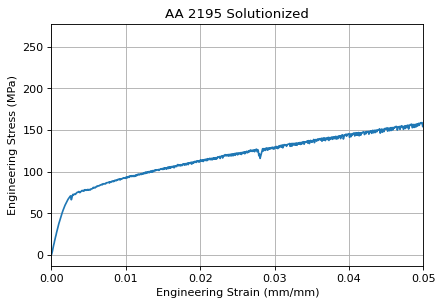

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in AA 2195 Solutionized's dataset: 0.003
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 68
Young's Modulus: 29.617332749346176 GPa


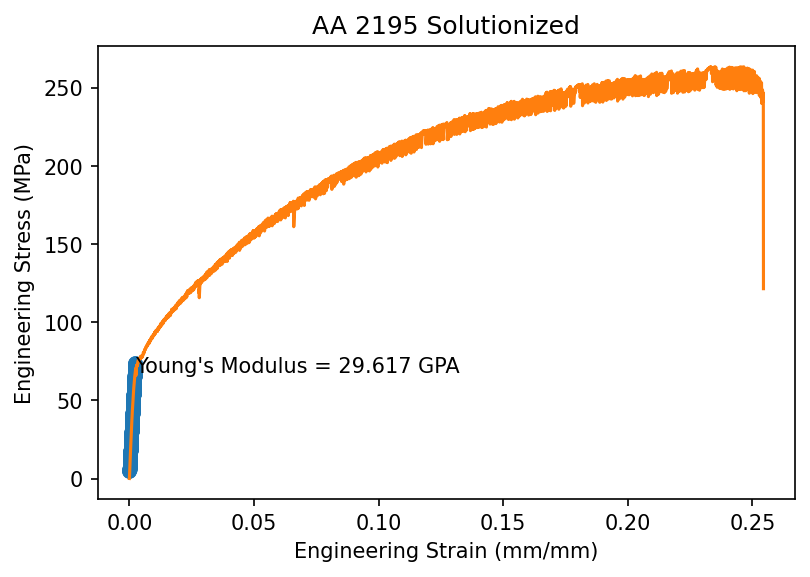

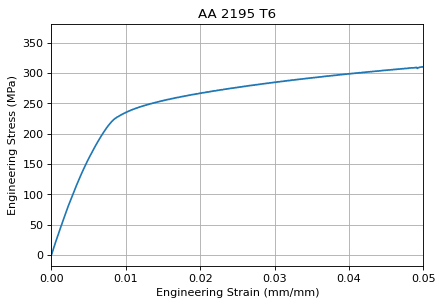

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in AA 2195 T6's dataset: 0.008
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 222
Young's Modulus: 26.992714051872607 GPa


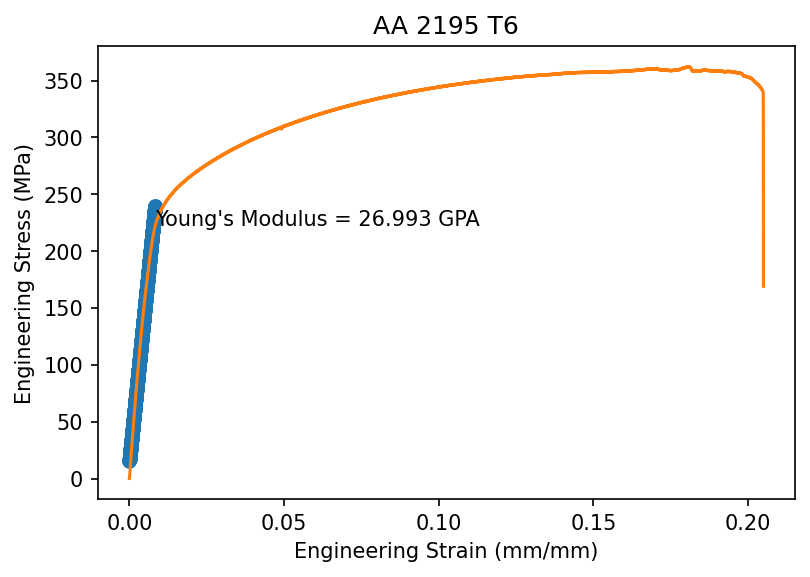

In [5]:
def decider(func):
    """
    Calls the executable if the user permits.
    :param executable: a function to be called if input allows
    :return: the wrapper funtion
    """

    def wrapper(message, parameter_exists, *args, **kwargs):
        if not parameter_exists:
            func(message, parameter_exists, *args, **kwargs)
        else:
            response = input(f'{message} (Y/n): ').lower()
            if response in ['y', 'yes']:
                func(message, parameter_exists, *args, **kwargs)
    return wrapper

youngs_modulus = []

@decider
def compute_ym(message, parameter_exists, i):
    fig1 , ax1 = plt.subplots(1,1) # Refers to plot from which user will observe values of e and s.
    fig1.set_dpi(80)

    strain_limit = 0.05
    ax1.plot(x[i], y_smooth[i])
    ax1.grid(True)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_xlim(0, strain_limit)
    ax1.set_title(PROJECT_NAME[i])
    plt.show()

    educated_guess_strain = float(input(
        'Enter the value of engineering strain upto which the line seems linear '
        f'(used in calculation of Youngs modulus) in the units same as in {PROJECT_NAME[i]}\'s dataset: '
        ))
    educated_guess_stress = float(input(
        'Enter the value of engineering stress upto which the line seems linear '
        '(used in calculation of Youngs modulus) in the units same as in dataset: '
        ))
    guessed_index = find_nearest(x[i], y_smooth[i], educated_guess_strain, educated_guess_stress)

    x_smooth = sm.add_constant(x[i]) 
    result = sm.OLS(y_smooth[i][:guessed_index], x_smooth[:guessed_index]).fit() 

    _, ym = result.params
    youngs_modulus[i] = ym

    if ifile[i].add_parameter('youngs_modulus', ym, True):
        ofile[i].save_parameter('Young\'s Modulus', ym, 'MPa')

    print(f'Young\'s Modulus: {ym/1000} GPa')

    y_linear = [(strain*ym + _) for strain in x[i]]

    fig2, ax2 = plt.subplots(1,1) # Linear line for elastic region identification
    ax2.plot(x[i][:guessed_index], y_linear[:guessed_index], marker='o')
    ax2.plot(x[i],y_smooth[i])
    ax2.set_title(PROJECT_NAME[i])
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

    ax2.annotate(f'Young\'s Modulus = {ym/1000:.3f} GPA', xy=(x[i][guessed_index], y[i][guessed_index]))

    fig2.set_dpi(150)
    fig2.savefig(f'{OUTPUT_DIR[i]}/Youngs modulus calculation', facecolor='white', transparent=True)
    plt.show()

for i in range(len(x)):
    ym_i = ifile[i].get_parameter('youngs_modulus')
    ym_exists = ym_i is not None
    if ym_exists:
        print(f'Young\'s modulus of {PROJECT_NAME[i]}: {ym_i} MPa')
    youngs_modulus.append(ym_i)
    compute_ym(
        f'{PROJECT_NAME[i]}\'s youngs\'s modulus already exists. Do you want to recompute?',
        ym_exists,
        i,
    )

#### Calculation of Yield strength ($\sigma_{ys}$)

Yield Strength: 447.88676 MPa


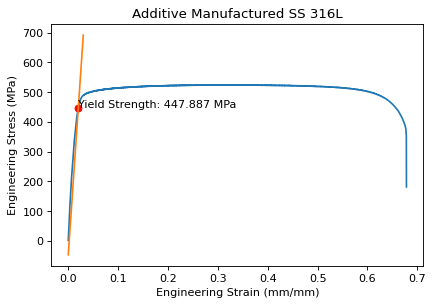

Yield Strength: 431.642972 MPa


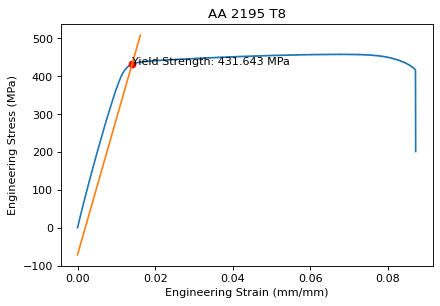

Yield Strength: 78.038544 MPa


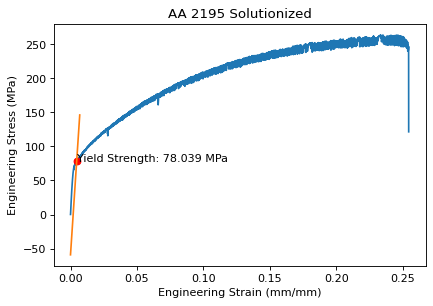

Yield Strength: 238.88962400000003 MPa


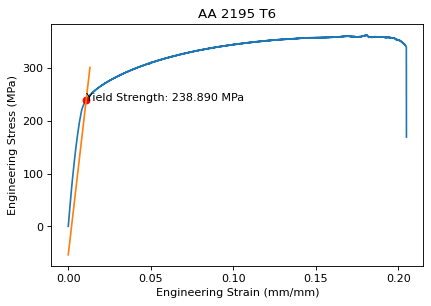

In [6]:
yield_strength = []
intersection = []

for i in range(len(x)):
    parallel_line_y = [(strain - 0.002)*youngs_modulus[i] for strain in x[i]]

    fig, ax = plt.subplots(1,1)
    ax.plot(x[i],y_smooth[i])

    ins = np.argwhere(np.diff(np.sign([parallel_line_y[stress] - y_smooth[i][stress] for stress in range(len(y_smooth[i]))]))).flatten()
    intersection.append(ins[0])
    ax.plot(x[i][ins[0]], y_smooth[i][ins[0]], 'ro')

    # 200 is added as a scaling factor so that the intersection point is easily viewable
    ax.plot(x[i][:(ins[0]+200)], parallel_line_y[:(ins[0]+200)])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(PROJECT_NAME[i])
    ys = y_smooth[i][ins[0]]
    yield_strength.append(ys)
    ax.annotate(f'Yield Strength: {ys:.3f} MPa', (x[i][ins[0]], y_smooth[i][ins[0]]))

    fig.set_dpi(80)
    fig.savefig(f'{OUTPUT_DIR[i]}/Yield Strength', facecolor='white', transparent=True, dpi=150)

    # 0th index because there is only one intersection point
    print(f'Yield Strength: {ys} MPa')
    plt.show()

    if ifile[i].add_parameter('yield_strength', ys):
        ofile[i].save_parameter('Yield Strength', ys, 'MPa')

## Calculation of Ultimate tensile strength ($\sigma_{uts}$)

Ultimate Tensile Strength is 524.425548 MPa at 31.816329999999997% elongation.
Ultimate Tensile Strength is 457.9231510000001 MPa at 6.798% elongation.
Ultimate Tensile Strength is 263.639546 MPa at 23.327% elongation.
Ultimate Tensile Strength is 362.20079200000004 MPa at 18.095% elongation.


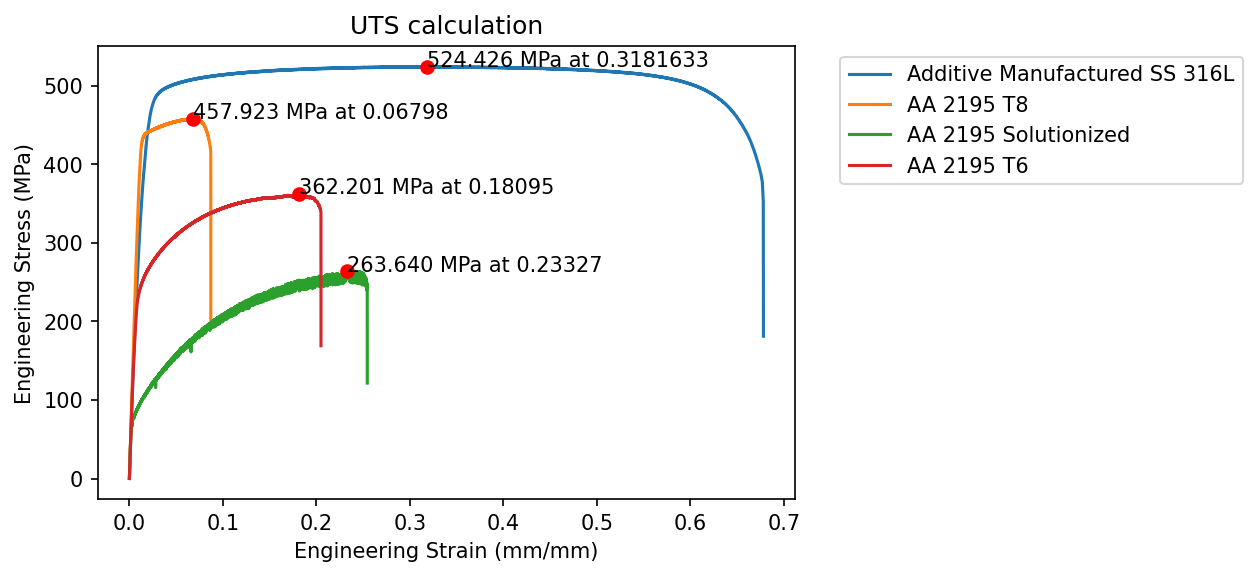

In [7]:
fig, ax = plt.subplots(1,1)
legends = []

uts_point = []

# Fetch the max value of the engineering stress from the dataset.
for i in range(len(x)):
    uts_abscissa = 0
    uts = y_smooth[i][uts_abscissa]
    for j in range(0,len(y_smooth[i])):
        if y_smooth[i][j] >= uts:
            uts = y_smooth[i][j]
            uts_abscissa = j
    uts_strain = x[i][uts_abscissa]

    uts_point.append(uts_abscissa)

    ax.plot(x[i],y_smooth[i], label=PROJECT_NAME[i])
    ax.plot(uts_strain, uts, 'ro', label=None)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('UTS calculation')
    ax.annotate(f'{uts:.3f} MPa at {uts_strain}', (uts_strain, uts))
    
    print(f'Ultimate Tensile Strength is {uts} MPa at {uts_strain*100}% elongation.')


    if ifile[i].add_parameter('uts', uts):
        ofile[i].save_parameter('Ultimate Tensile Strength', uts, 'MPa')

    if ifile[i].add_parameter('uts_strain', uts_strain):
        ofile[i].save_parameter('Uniform Elongation', uts_strain, '')

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))   
fig.set_dpi(150)
plt.show()
_ = fig.savefig(f'{COMBINED_OUTPUT_DIR}/UTS calculation', facecolor='white', transparent=True, bbox_inches='tight')

### Plastic Region

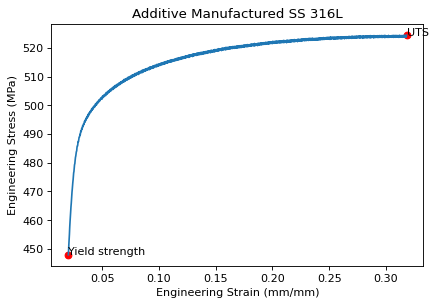

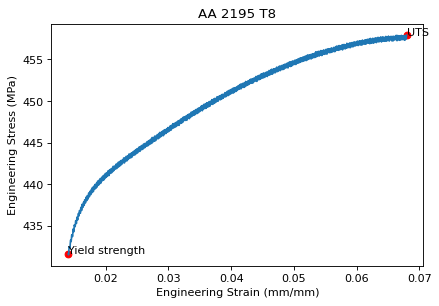

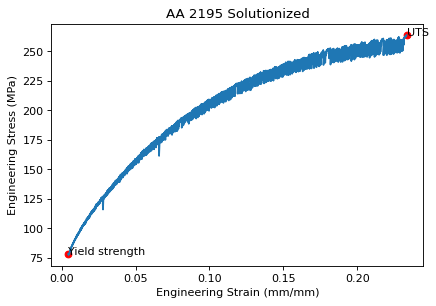

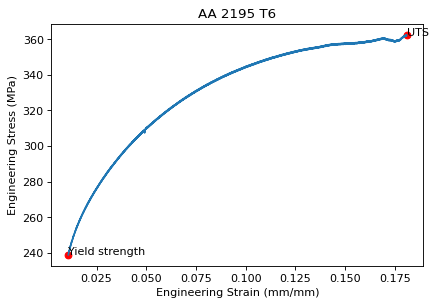

In [8]:
start = []
end = []

for i in range(len(x)):
    fig, ax = plt.subplots(1,1)
    fig.set_dpi(80)
    
    ax.plot(x[i][intersection[i]], y_smooth[i][intersection[i]], 'ro', label=None) # YS
    ax.plot(x[i][uts_point[i]], y_smooth[i][uts_point[i]], 'ro', label=None) # UTS

    ax.annotate(
        'Yield strength',
        xy=(x[i][intersection[i]], y_smooth[i][intersection[i]]),
    ),
    ax.annotate(
        'UTS', 
        xy=(x[i][uts_point[i]], y_smooth[i][uts_point[i]]),
    )
    ax.set_title(PROJECT_NAME[i])

    # there is only one intersection point
    st = intersection[i]
    e = uts_point[i]+1
    start.append(st)
    end.append(e)
    ax.plot(x[i][st:e], y_smooth[i][st:e], label=PROJECT_NAME[i])

    # supresses ouput while setting x,y labels
    _ = ax.set_xlabel(x_label)
    _ = ax.set_ylabel(y_label)

In [9]:
x_plastic_region = []
y_smooth_plastic_region = []

for i in range(len(x)):
    x_plastic_region.append(x[i][start[i]:end[i]])
    y_smooth_plastic_region.append(y_smooth[i][start[i]:end[i]])

    pd.DataFrame(
        np.transpose(np.asarray([x_plastic_region[i], y_smooth_plastic_region[i]]))
    ).to_csv(f'{OUTPUT_DIR[i]}/plastic_region.csv', index=False, header=False)